In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math 
import xgboost as xbg
from scipy.stats import skew
from scipy import stats

import statsmodels
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(1337)

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

train['train'] = 1
test['test'] = 0
data = pd.concat([train, test], axis=0)

In [7]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train,test
PassengerId,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0,NaN
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,NaN
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,NaN
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,NaN
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.0,NaN


In [8]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,train,test
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,891.0,418.0
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,1.0,0.0
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.0,0.0
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.0,0.0
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,1.0,0.0
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0,0.0
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.0,0.0
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.0,0.0


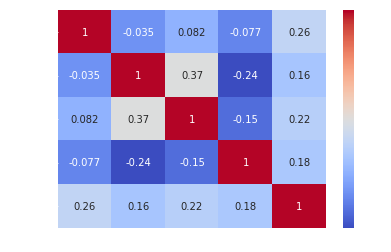

In [15]:
# let's look at the correlation between our varibles. 
g = sns.heatmap(data[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, cmap= "coolwarm")

Let's take a look at each variables relationship to each other and see if we can find some features to use in our model. 

In [11]:
data[["Parch", "Survived"]][data.Survived.isnull()==False].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


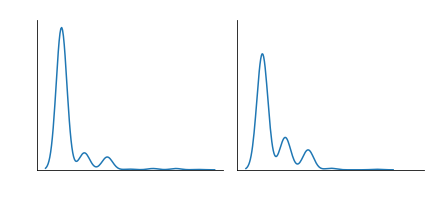

In [16]:
k = sns.FacetGrid(data, col='Survived')
k = k.map(sns.distplot, "Parch", hist=False)

In [17]:
data[["SibSp", "Survived"]][data.Survived.isnull()==False].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


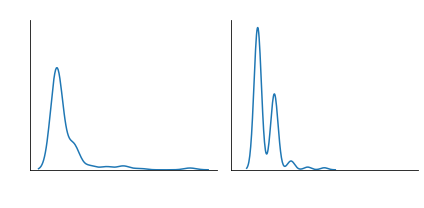

In [18]:
g = sns.FacetGrid(data, col='Survived')
g = g.map(sns.distplot, "SibSp", hist=False)

c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


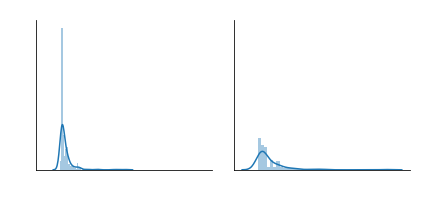

In [19]:
g = sns.FacetGrid(data, col='Survived')
g = g.map(sns.distplot, "Fare")

c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


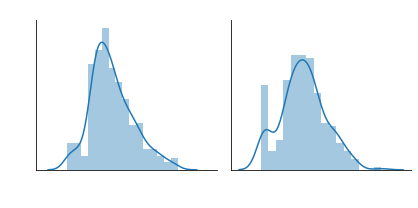

In [20]:
g = sns.FacetGrid(data, col='Survived')
g = g.map(sns.distplot, "Age")

In [21]:
data[["Sex","Survived"]].groupby('Sex').mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [22]:
data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


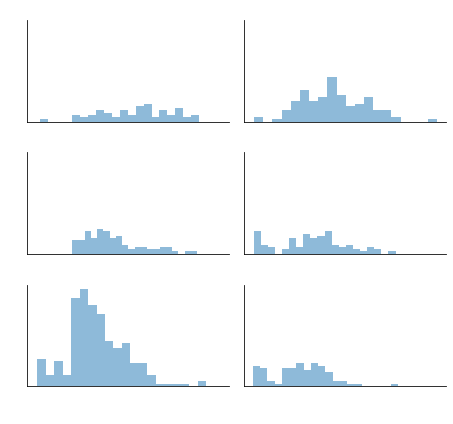

In [23]:
grid = sns.FacetGrid(data, col='Survived', row='Pclass', size=2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)

c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\users\greg\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


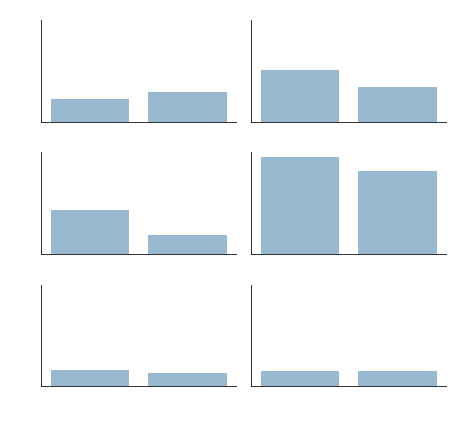

In [24]:
grid = sns.FacetGrid(data, row='Embarked', col='Survived', size=2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)

In [25]:
# Let's check for missing data. 
data.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
train        418
test         891
dtype: int64

In [26]:
# let's dig a little deeper here, we will probably have to imput the ages since we are missing so many from the 
# cabins column.
data.groupby('Pclass').Fare.mean()

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [27]:
data.Fare = data.Fare.fillna(0)

In [28]:
print(data.Embarked.value_counts())
data.Embarked = data.Embarked.fillna('S')

S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [29]:
data.Cabin = data.Cabin.fillna('Unknown')
data['Cabin'] = data['Cabin'].str[0]

In [30]:
# let's check the distribution of cabins for individual passenger classes. 
data.groupby('Pclass').Cabin.value_counts()

Pclass  Cabin
1       C         94
        U         67
        B         65
        D         40
        E         34
        A         22
        T          1
2       U        254
        F         13
        D          6
        E          4
3       U        693
        F          8
        G          5
        E          3
Name: Cabin, dtype: int64

In [31]:
data['Cabin'] = np.where((data.Pclass==1) & (data.Cabin=='U'),'C',
                                            np.where((data.Pclass==2) & (data.Cabin=='U'),'D',
                                            np.where((data.Pclass==3) & (data.Cabin=='U'),'G',
                                            np.where(data.Cabin=='T','C',data.Cabin))))